In [51]:
### Importing the dataset - in the form of batches - using dataloader package - mini batch descent - size =64
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MLP_torch(nn.Module):
    def __init__(self, input_layer_size=784, first_hidden_layer_size=500, 
                 second_hidden_layer_size=250, third_hidden_layer_size=100, 
                 output_layer_size=10,regulatisation_constant = 0.0001):
        super(MLP_torch, self).__init__()
        self.regularisation_constant = regulatisation_constant
        self.first_layer = nn.Linear(input_layer_size, first_hidden_layer_size)
        self.second_layer = nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
        self.third_layer = nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
        self.output_layer = nn.Linear(third_hidden_layer_size, output_layer_size)

    def forward(self, x):
        x = torch.sigmoid(self.first_layer(x))
        x = torch.sigmoid(self.second_layer(x))
        x = torch.sigmoid(self.third_layer(x))
        x = self.output_layer(x)  
        x = torch.softmax(x, dim=1)
        return x

    def entropy_class_loss(self, Y, Y_hat):
        epsilon = 1e-10
        Y_hat = torch.clamp(Y_hat, epsilon, 1 - epsilon)
        
        loss = -torch.sum(Y * torch.log(Y_hat)) / Y.size(0)
        
    
        l2_norm_sum = 0
        for param in self.parameters():
            param_norm = torch.norm(param, p=2)  
            l2_norm_sum += param_norm

        return loss + self.regularisation_constant*l2_norm_sum


Current Iteration 200, Training Loss: 14.8370, Test Loss: 10.3845
Current Iteration 400, Training Loss: 11.9816, Test Loss: 8.0058
Current Iteration 600, Training Loss: 10.6772, Test Loss: 7.9521
Current Iteration 800, Training Loss: 9.9824, Test Loss: 7.6136
Epoch 1/15 
Current Iteration 1000, Training Loss: 7.7351, Test Loss: 7.5165
Current Iteration 1200, Training Loss: 7.5839, Test Loss: 7.5872
Current Iteration 1400, Training Loss: 7.6201, Test Loss: 7.6701
Current Iteration 1600, Training Loss: 7.6275, Test Loss: 7.5003
Current Iteration 1800, Training Loss: 7.6283, Test Loss: 7.4399
Epoch 2/15 
Current Iteration 2000, Training Loss: 5.2271, Test Loss: 4.3022
Current Iteration 2200, Training Loss: 4.5080, Test Loss: 4.2277
Current Iteration 2400, Training Loss: 4.3342, Test Loss: 4.1028
Current Iteration 2600, Training Loss: 4.0838, Test Loss: 2.5926
Current Iteration 2800, Training Loss: 3.6474, Test Loss: 2.0018
Epoch 3/15 
Current Iteration 3000, Training Loss: 1.6120, Test Lo

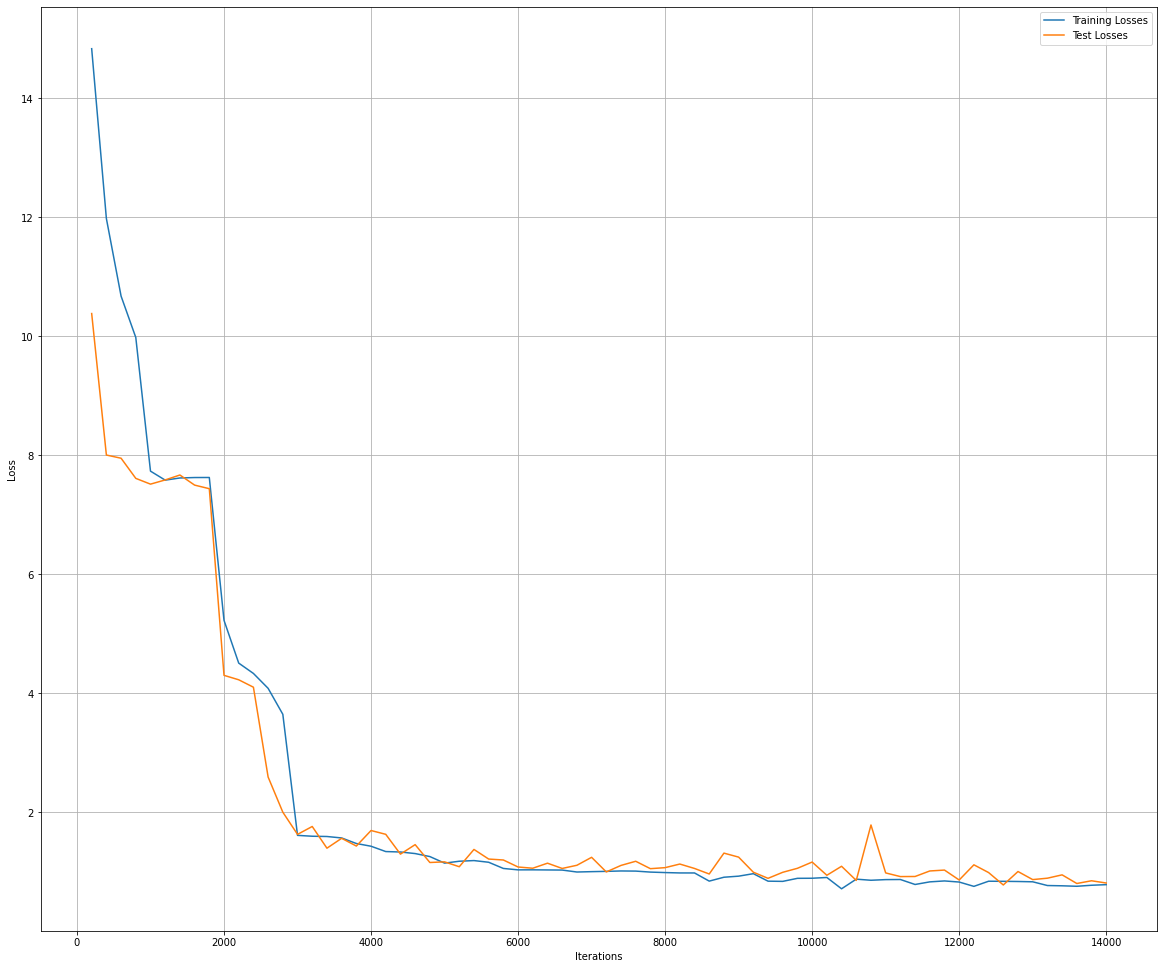

In [53]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.nn.functional as F
import torch.nn.functional as F

def train(model, optimizer, train_loader, test_loader, epochs, plot_interval=200, device='cpu'):
    training_loss_list = []
    test_loss_list = []
    iteration_counts = []
    current_iteration = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.view(images.size(0), -1).to(device), labels.to(device)
            labels_one_hot = F.one_hot(labels, num_classes=10).float().to(device)  
            optimizer.zero_grad()
            outputs = model(images)
            loss = model.entropy_class_loss(outputs, labels_one_hot)  
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            current_iteration += 1

            if current_iteration % plot_interval == 0:
                iteration_counts.append(current_iteration)
                avg_train_loss = running_loss / (batch_idx + 1)
                training_loss_list.append(avg_train_loss)

                model.eval()
                total_test_loss = 0
                total_test_samples = 0
                with torch.no_grad():
                    for test_images, test_labels in test_loader:
                        test_images, test_labels = test_images.view(test_images.size(0), -1).to(device), test_labels.to(device)
                        
                        test_outputs = model(test_images)
                        test_labels_one_hot = F.one_hot(test_labels, num_classes=10).float().to(device)
                        test_loss = model.entropy_class_loss(test_outputs, test_labels_one_hot) 
                        total_test_loss += test_loss.item() * test_images.size(0)
                        total_test_samples += test_images.size(0)
                
                avg_test_loss = total_test_loss / total_test_samples
                test_loss_list.append(avg_test_loss)
                print(f'Current Iteration {current_iteration}, Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

        print(f'Epoch {epoch + 1}/{epochs} ')

    plt.figure(figsize=(20, 17))
    plt.plot(iteration_counts, training_loss_list, label='Training Losses')
    plt.plot(iteration_counts, test_loss_list, label='Test Losses')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

model = MLP_torch()
optimizer = Adam(model.parameters())
train(model, optimizer, train_loader, test_loader, epochs=15)


In [54]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def final_test(model, test_loader):
    model.eval()  
    all_preds = []
    all_labels = []
    with torch.no_grad(): 
        for images, labels in test_loader:
            images = images.view(images.size(0), -1)
            outputs = model(images) 
            _, preds = torch.max(outputs, 1)  
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Final Test Accuracy: {accuracy * 100:.2f}%')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(20, 17))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



Final Test Accuracy: 96.27%


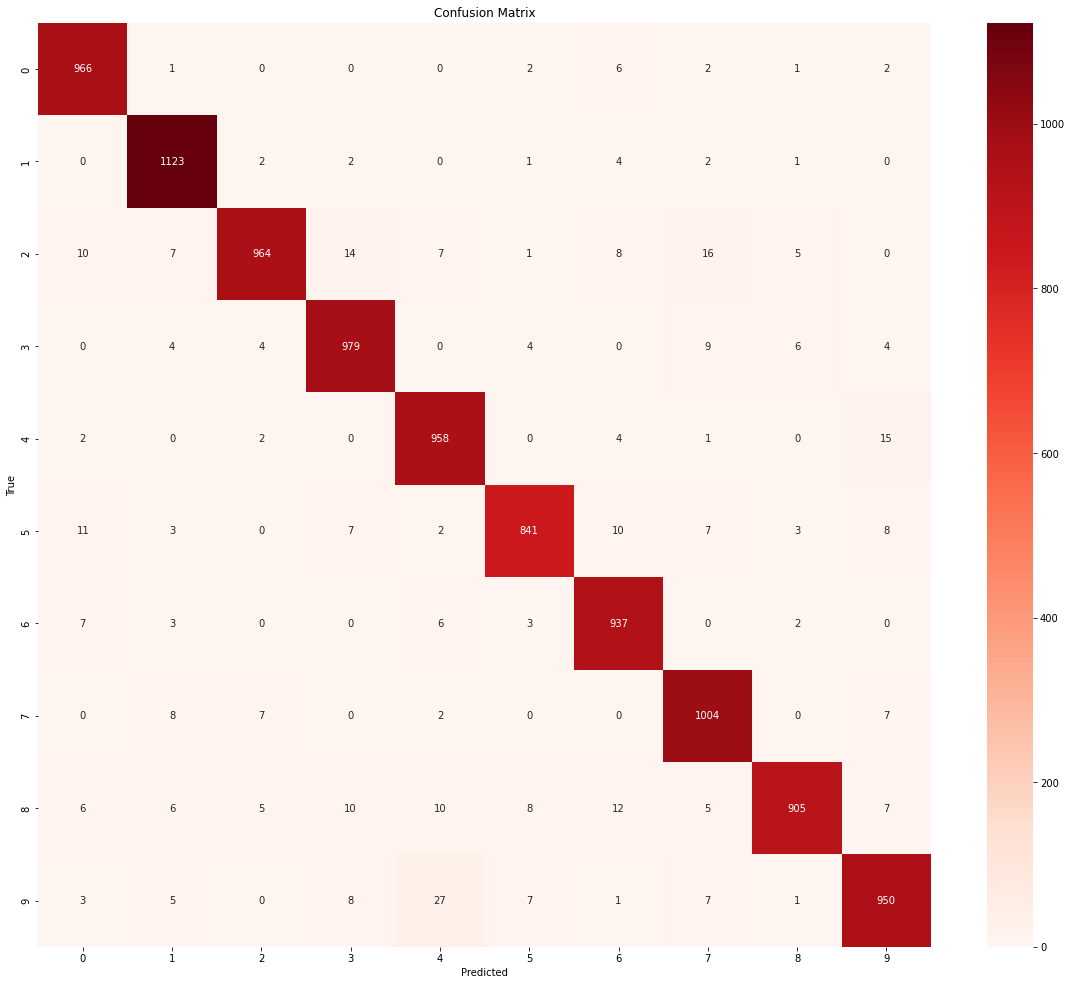

In [55]:

final_test(model, test_loader)


Final Test Accuracy: 97.17%


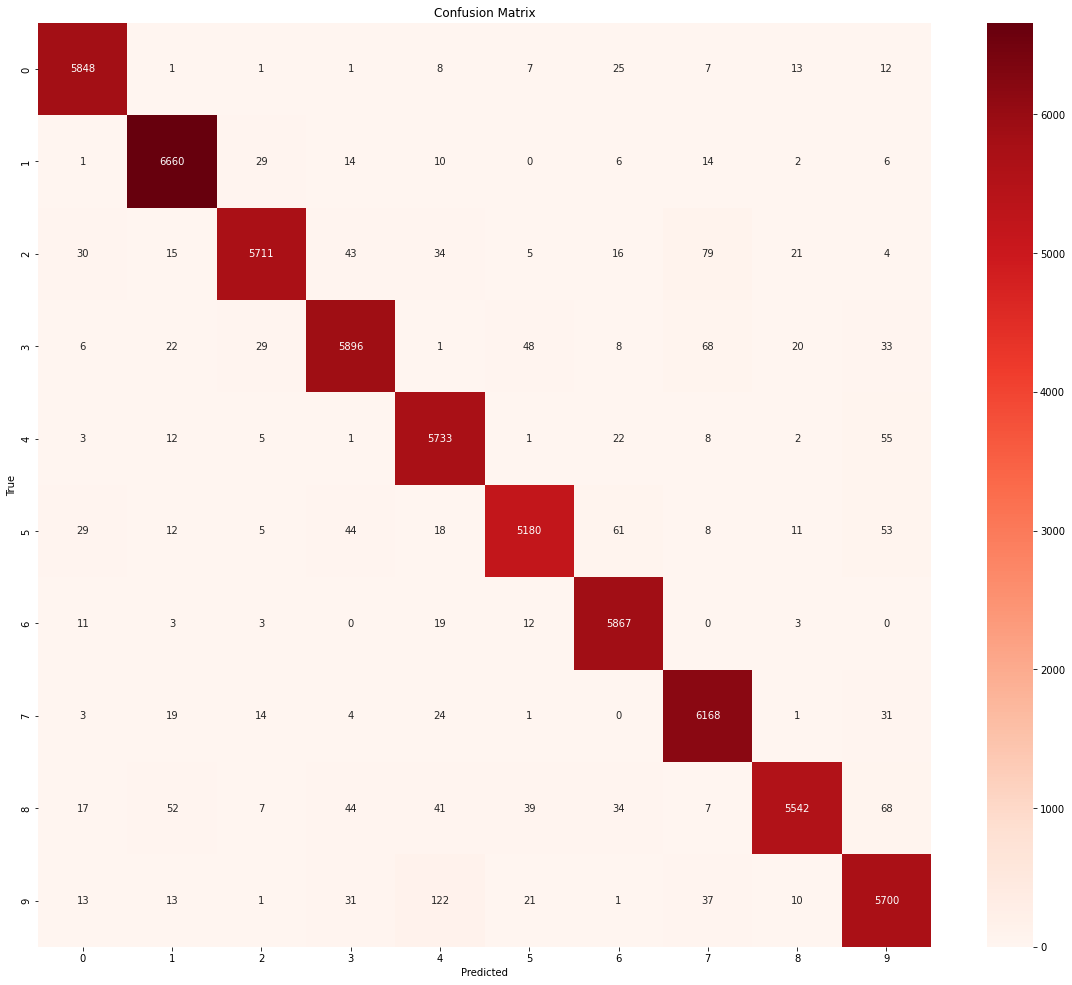

In [56]:

final_test(model, train_loader)
